## Profiling the speedup of the new code with Numba

In [1]:
import unittest
import numpy as np
import igl
import time
import matplotlib.pyplot as plt
import importlib
import random
import cProfile

import rainbow.cuda.geometry.grid3 as CUDAGRID
import rainbow.geometry.grid3 as GRID
import rainbow.geometry.volume_mesh as VM
from numba import cuda

from tqdm import tqdm
import rainbow.math.vector3 as V3
import rainbow.simulators.prox_soft_bodies.api as API
import rainbow.simulators.prox_soft_bodies.solver as SOLVER
import rainbow.util.viewer as VIEWER
from rainbow.util.USD import USD

importlib.reload(API)
importlib.reload(SOLVER)
importlib.reload(CUDAGRID)

# colors for visualization
v3_colors = [
    V3.make(0.90, 0.10, 0.29),
    V3.make(0.24, 0.71, 0.29),
    V3.make(1.00, 0.88, 0.10),
    V3.make(0.26, 0.39, 0.85),
    V3.make(0.96, 0.51, 0.19),
    V3.make(0.57, 0.11, 0.71),
    V3.make(0.28, 0.94, 0.94),
    V3.make(0.95, 0.20, 0.90),
    V3.make(0.74, 0.96, 0.05),
    V3.make(0.98, 0.74, 0.75),
    V3.make(0.00, 0.50, 0.50),
    V3.make(0.90, 0.75, 1.00),
    V3.make(0.60, 0.39, 0.14),
    V3.make(1.00, 0.98, 0.78),
    V3.make(0.50, 0.00, 0.00),
    V3.make(0.67, 1.00, 0.76),
    V3.make(0.50, 0.50, 0.00),
    V3.make(1.00, 0.85, 0.69),
    V3.make(0.00, 0.00, 0.46),
    V3.make(0.50, 0.50, 0.50),
    V3.make(1.00, 1.00, 1.00),
    V3.make(0.00, 0.00, 0.00)
]


MODEL_MAP = {
    'SVK': API.SVK,
    'COR': API.COR,
    'SNH': API.SNH
}


# create a soft material into a scene
def create_soft_material(engine, name=None, model_name='SVK', friction=0.5):
    model = MODEL_MAP[model_name]
    E, nu, rho = API.create_material_parameters(name) # if name == None, default values , E = 10e5 nu = 0.3 rho = 1000  

    API.create_material(engine, 'soft_mat1')
    API.set_elasticity(engine, 'soft_mat1', E, nu)
    API.set_mass_density(engine, 'soft_mat1', rho)
    API.set_constitutive_model(engine, 'soft_mat1', model)
    API.set_viscosity(engine, 'soft_mat1', 0.5)
    API.create_surfaces_interaction(engine,'soft_mat1','soft_mat1', friction)

# create the soft beam into a scene
def create_soft_beam(engine, geo, gravity=-10, material='soft_mat1', name='beam'):
    V_beam, T_beam = VM.create_beam(*geo) # geometry 
    
    # V_beam[:,0] -= random.uniform(-4.0, -1.5)
    # V_beam[:,1] += random.uniform(0.275, 0.276)
    # V_beam[:,2] -= random.uniform(-1.5, 1.5)
    API.create_soft_body(engine, name, V_beam, T_beam)
    API.set_type(engine, name, "Free")
    API.set_gravity(engine, name, (0,gravity,0))
    API.set_material(engine, name, material)
    return len(T_beam)
    
# create the wall into a scene
def create_wall(engine):
    V_wall, T_wall = VM.create_beam(2, 2, 2, 0.1, 8.0, 8.0)
    V_wall[:,0] -= 2.05
    API.create_soft_body(engine, 'wall', V_wall, T_wall)
    API.set_type(engine, 'wall', "Fixed")
    API.set_gravity(engine, 'wall', (0,0,0))
    API.set_material(engine,'wall','soft_mat1')

# initialize the viewer
def initialize_viewer(engine, viewer, usd):
    # viewer.create_frame("origin")
    for body in engine.bodies.values():    
        opacity = 0.5
        F = VM.to_triangles(body.T)
        color = random.choice(v3_colors)
        viewer.create_mesh(body.name, body.x0, F, color, opacity)   
        # add mesh to usd
        usd.add_mesh(body.name, body.x0, F, color)

    viewer.show()

def simulate(engine, T = 1.0, render_fps=60.0, non_update_bodies=[], update_traction=False):
    sim_dt = engine.params.time_step
    sim_fps = 1.0 / sim_dt
    render_dt = 1 / render_fps
    render_steps = int(np.round(T / render_dt))
    # usd.set_animation_time(T*render_fps) # set the simulation ending time  in usd

    for step in tqdm(range(render_steps), desc="Rendering Loop:"):
        dT = render_dt 
        while dT > 0: # do simulation block
            dt = min(dT, sim_dt) # generally, sim_dt < render_dt
            API.simulate(engine, dt, debug_on=True)
            dT -= dt
            # upadte_viewer(engine, viewer, non_update_bodies)
        # upadte_usd(engine, usd, step*render_dt*render_fps, non_update_bodies)

    return API.get_log(engine)

def plot_profile(normal, speedup, title='Execution Time Comparison: Previous vs Speedup'):
    plt.figure(figsize=(10, 6))
    plt.plot(normal, '-o', label='Previous')
    plt.plot(speedup, '-o', label='Speedup')
    plt.xlabel('Frame')
    plt.ylabel('Execution Time (seconds)')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

def get_computing_time(stats, time_phase_name):
    times = [ stats[i][time_phase_name] for i in range(1, len(stats)) ]
    # time_elastic_forces = [ stats[i]['compute_elastic_forces'] for i in range(1, len(stats)) ]
    # time_traction_forces = [ stats[i]['compute_traction_forces'] for i in range(1, len(stats)) ]
    # time_damping_forces = [ stats[i]['compute_damping_forces'] for i in range(1, len(stats)) ]
    # time_external_forces = [ stats[i]['compute_external_forces'] for i in range(1, len(stats)) ]
    # time_update_bvh = [ stats[i]['update_bvh'] for i in range(1, len(stats)) ]
    # time_narrow_phase = [ stats[i]['narrow_phase'] for i in range(1, len(stats)) ]
    # time_contact_determination = [ stats[i]['contact_determination'] for i in range(1, len(stats)) ]
    # time_contact_point_reduction = [ stats[i]['contact_point_reduction'] for i in range(1, len(stats)) ]
    # time_collision_detection = [ stats[i]['collision_detection_time'] for i in range(1, len(stats)) ]
    # time_stepper = [ stats[i]['stepper_time'] for i in range(1, len(stats)) ]
    # time_kinetic_energy = [ stats[i]['compute_kinetic_energy'] for i in range(1, len(stats)) ]
    # time_poential_energy = [ stats[i]['compute_potential_energy'] for i in range(1, len(stats)) ]
    # time_elastic_energy = [ stats[i]['compute_elastic_energy'] for i in range(1, len(stats)) ]

    # time_elastic_forces = np.array(time_elastic_forces)
    # time_traction_forces = np.array(time_traction_forces)
    # time_damping_forces = np.array(time_damping_forces)
    # time_external_forces = np.array(time_external_forces)
    # time_update_bvh = np.array(time_update_bvh)
    # time_narrow_phase = np.array(time_narrow_phase)
    # time_contact_determination = np.array(time_contact_determination)
    # time_contact_point_reduction = np.array(time_contact_point_reduction)
    # time_collision_detection = np.array(time_collision_detection)
    # time_stepper = np.array(time_stepper)
    # time_kinetic_energy = np.array(time_kinetic_energy)
    # time_poential_energy = np.array(time_poential_energy)
    # time_elastic_energy = np.array(time_elastic_energy)

    # total_time = time_elastic_forces.sum() + time_traction_forces.sum() + time_damping_forces.sum() + time_external_forces.sum() + time_update_bvh.sum() + time_narrow_phase.sum() + time_contact_determination.sum() + time_contact_point_reduction.sum() + time_collision_detection.sum() + time_stepper.sum() + time_kinetic_energy.sum() + time_poential_energy.sum() + time_elastic_energy.sum()

    # total_time_contact_point_reduction = time_contact_point_reduction.sum()

    return times

def create_complex_scene(number_cell = 5, material=None, model='SNH', time_step=0.0001, speedup=True):
    scene = API.create_engine()
    scene.params.time_step = time_step
    viewer = VIEWER.Viewer()

    create_soft_material(scene, material, model) 

    T1 = create_soft_beam(scene, (number_cell, number_cell, number_cell, 2, 2, 2), name="cube")
    T2 = create_soft_beam(scene, (number_cell, number_cell, number_cell, 4, 0.05, 4), name="surface")

    API.create_dirichlet_conditions(scene, 'surface', lambda x: x[0] + 1.9)
    API.create_dirichlet_conditions(scene, 'surface', lambda x: 1.9 - x[0])

    usd = USD("complex_scene"+ str(number_cell) +".usd")
    # initialize_viewer(scene, viewer, usd)
    usd.save()

    scene.params.speedup = speedup
    stats = simulate(scene, T = 0.05)
    return stats, T1+T2

In [2]:
def profile_speedup(number_objects, time_phase_name, title):
    stats_speedup = []
    stats_normal = []
    number_tets = []

    number_objects = [4]

    for number in number_objects:

        print("number : ", number)

        complex_stats_normal, number_tet = create_complex_scene(number, speedup=False)
        stats_normal.append(complex_stats_normal)

        complex_stats_speedup, number_tet = create_complex_scene(number, speedup=True)
        stats_speedup.append(complex_stats_speedup)

        number_tets.append(number_tet)

    for i in range(len(number_objects)):
        total_item_time_speedup = get_computing_time(stats_speedup[i], time_phase_name)
        total_item_time_normal = get_computing_time(stats_normal[i], time_phase_name)
        print("number of tets: ", number_tets[i])
        # print("total time speedup: ", total_time_speedup)
        # print("total time normal: ", total_time_normal)
        print("total time {}: ".format(time_phase_name), np.array(total_item_time_speedup).sum())
        print("total time {}: ".format(time_phase_name), np.array(total_item_time_normal).sum())
        # print("speed up: ", total_time_normal / total_time_speedup)
        print("speed up in this phase: ", np.array(total_item_time_normal).sum() /np.array(total_item_time_speedup).sum())
    
    plot_profile(total_item_time_normal, total_item_time_speedup, title=title)

### Speedup of the contact points reduction phase
The time complexity of the contact points reduction phase is $O(n^2)$ previously, where $n$ is the number of particles. We use the python Dict to reduce the time complexity to $O(n)$.

number :  4


Rendering Loop::   0%|          | 0/3 [00:00<?, ?it/s]/home/qbp758/anaconda3/envs/sim/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/qbp758/anaconda3/envs/sim/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/home/qbp758/anaconda3/envs/sim/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
Rendering Loop:: 100%|██████████| 3/3 [02:22<00:00, 47.36s/it]


number of tets:  270
total time contact_point_reduction:  0.0008990932255983353
total time contact_point_reduction:  5.052639065310359
speed up in this phase:  5619.7054114693065


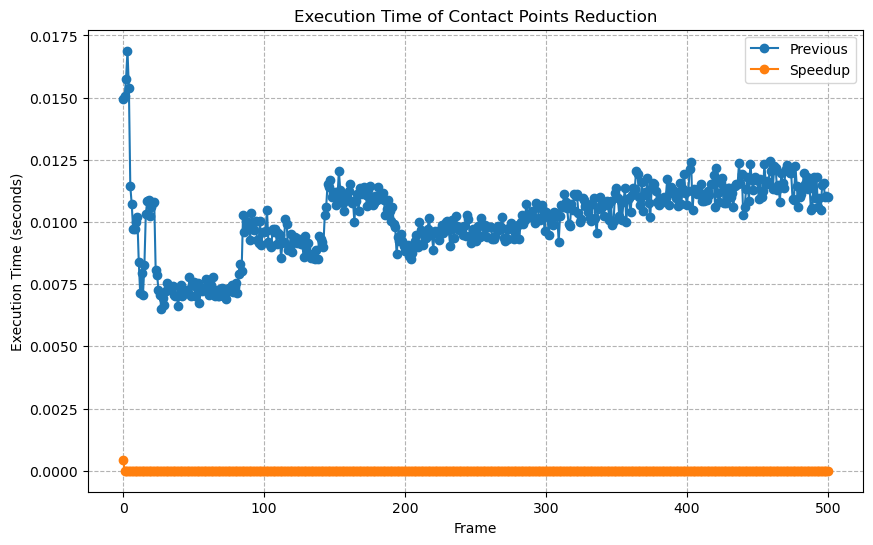

In [5]:

profile_speedup(4, 'contact_point_reduction', title='Execution Time of Contact Points Reduction')